In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
!pip install emoji
import emoji
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
# Import word_tokenize
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
# Download punkt for word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df = pd.read_csv("/content/YoutubeCommentsDataSet.csv")
df

,Comment,Sentiment
0,lets not forget that apple pay in 2014 required a brand new iphone in order to use it a significant portion of apples user base wasnt able to use it even if they wanted to as each successive iphone incorporated the technology and older iphones were replaced the number of people who could use the technology increased,neutral
1,here in nz 50 of retailers don’t even have contactless credit card machines like paywave which support apple pay they don’t like the high fees that come with these,negative
2,i will forever acknowledge this channel with the help of your lessons and ideas explanations now its quite helpful while youll just sit at your comfort and monitor your account growth,positive
3,whenever i go to a place that doesn’t take apple pay doesn’t happen too often it’s such a drag between ‘contactless covid’ habits and my getting the apple card i’ve gotten so used to apple pay that i get seriously annoyed when a store doesn’t take it it feels like a shock it’s crazy how quickly it took over my shopping routine i’ve officially been brainwashed by apple because now it feels so inconvenient to even carry a physical card in my pocket,negative
4,apple pay is so convenient secure and easy to use i used it while at the korean and japanese airports no need for physical credit cards,positive
...,...,...
18403,i really like the point about engineering toolboxes i think that’s where a lot of the burnout comes from i work in devops and teach full stack so going to school for machine learning sounds like a large leap learning how to build better ml pipelines are much more worth my time,positive
18404,i’ve just started exploring this field and this was a really good reminder to get so early on the journey thanks a lot,positive
18405,excelente video con una pregunta filosófica profunda gracias por compartir esta reflexión sobre la base de tu experiencia pregunta cuáles son las tres herramientas framework data base and code writing de las que hablaste en el vídeo que tú usas,neutral
18406,hey daniel just discovered your channel a couple days ago and im learning lots thank you,positive


In [ ]:
print("Initial shape:", df.shape)
print("Sentiment distribution:\n", df['Sentiment'].value_counts())
df.dropna(subset=['Comment'], inplace=True)

Initial shape: (18408, 2)
Sentiment distribution:
 Sentiment
positive    11432
neutral      4638
negative     2338
Name: count, dtype: int64


In [ ]:
df.isnull().sum()

,0
Comment,0
Sentiment,0


<ipython-input-50-1fd676c88319>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='Blues')


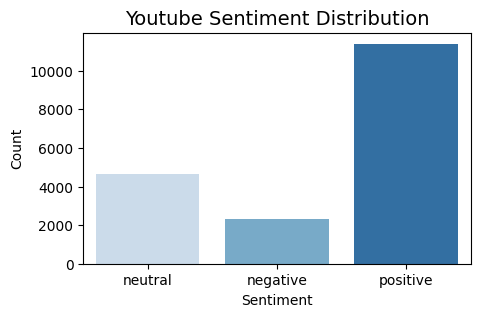

In [ ]:
# Distribution of the sentiments (Bar Chart)
plt.figure(figsize=(5, 3))
sns.countplot(x='Sentiment', data=df, palette='Blues')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Youtube Sentiment Distribution', fontsize=14)
plt.show()

In [ ]:
# Extract and view 5 random comments for positive sentiment category
positive_comments = df[df['Sentiment'] == 'positive'].sample(n=5, random_state=42)
display(positive_comments[['Comment', 'Sentiment']])

,Comment,Sentiment
12564,happy to see chandler winning sometimes,positive
3055,thank you really much a great thing to learn during lockdown times,positive
6415,putting up the name cards whenever you mention or remention people or say ‘he’ is an underrated genius move it’s so easy to keep track thanks to it wish other documentaries would do that,positive
18139,a year ago i used this video to explain to my class what artificial intelligence was or something like that i dont remember since i live in mexico i had to translate and explain everything thanks for the video i learned my classmates were entertained and i gave my teacher a good impression,positive
2759,so you recorded over 35 hours of excellent content without any fillers or fluff posted on youtube without monetizing with adds hats off to you,positive


In [ ]:
# Extract and view 5 random comments for negative sentiment category
positive_comments = df[df['Sentiment'] == 'negative'].sample(n=5, random_state=42)
display(positive_comments[['Comment', 'Sentiment']])

,Comment,Sentiment
13086,it would be an insult to american justice system for trump to get away with his accountability,negative
14426,imagine this guy with his personality if he is not rich,negative
11083,lyrics here we go again i kinda wanna be more than friends so take it easy on me im afraid youre never satisfied here we go again were sick like animals we play pretend youre just a cannibal and im afraid i wont get out alive no i wont sleep tonight oh oh i want some more oh oh what are you waiting for take a bite of my heart tonight oh oh i want some more oh oh what are you waiting for what are you waiting for say goodbye to my heart tonight here we are again i feel the chemicals kickin in its getting heavy and i wanna run and hide i wanna run and hide i do it every time youre killin me now and i wont be denied by you the animal inside of you oh oh i want some more oh oh what are you waiting for take a bite of my heart tonight oh oh i want some more oh oh what are you waiting for what are you waiting for say goodbye to my heart tonight hush hush the world is quiet hush hush we both cant fight it its us that made this mess why cant you understand whoa i wont sleep tonight i wont sleep tonight here we go again 3x oh oh i want some more oh oh what are you waiting for take a bite of my heart tonight oh oh i want some more oh oh what are you waiting for what are you waiting for what are you waiting here we go again oh oh 3x say goodbye to my heart tonight oh oh i want some more oh oh what are you waiting for what are you waiting for say goodbye to my heart tonight,negative
17846,unreal engine left the chat,negative
15625,as someone i used to work for gamestop my advice is to always buy the used system over the refurbished ones the refurbished ones were broken at one point and whoever fixes them doesnt do a great job,negative


In [ ]:
# Extract and view 5 random comments for neutral sentiment category
positive_comments = df[df['Sentiment'] == 'neutral'].sample(n=5, random_state=42)
display(positive_comments[['Comment', 'Sentiment']])

,Comment,Sentiment
4729,magnus shows the kid how chess speaks for itself,neutral
13063,50 years of weed and never been in trouble with the law never been a slacker at school or work raised a good decent family nothing wrong with weed besides whens the last time you heard of weed related road rage never,neutral
5941,051 how did you hear about this job 106 what do you know about our company so far 139 tell me about yourself 212 what determined you to make such a bold career shift 332 how long have you been working for soft solutions 340 why do you want to leave that job 355 what exactly made you apply for this job at our company 410 what are your strengths 433 can you provide an example of how you acted as a team player 500 what would you do if you didnt get on with someone on your team 514 what are your weaknesses 529 where do you see yourself in 5 years 554 do you work well under pressure 621 can you tell me about a recent accomplishment or success you had,neutral
16778,2323 hermosa elección love18kissxuno los mortales abian apreciado tan hermosa mujer 209 elecciones 95103 culturales 93 🅻🅸🆅🅴 1010 hopi sweeter 1112 sun hotter 0018 joonie cooler 1800 yoongy butter 2323 son unos de los mejores conciertos mañas no se la 1515 las elecciones cinematográficas y artísticas son brillantes referencias culturales europeas realmente interesantes ojalá la cultura europea se representara más a menudo tan bellamente no puedo dejar de decir oh esto es hermoso a lo largo del video luz en serio el que se encargue de la iluminación genial stayhomebufferingbuffering,neutral
4289,bahot hard,neutral


In [ ]:
#Data Preprocessing

import nltk
nltk.download('punkt_tab')

stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

contractions = {
    "can't": "cannot", "won't": "will not", "n't": " not", "'re": " are",
    "'s": " is", "'d": " would", "'ll": " will", "'t": " not", "'ve": " have", "'m": " am"
}

def clean_text(text):
    text = str(text).lower()
    for c, e in contractions.items():
        text = re.sub(c, e, text)
    text = emoji.replace_emoji(text, replace='')  # Remove emojis
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)  # Remove mentions and hashtags
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove non-alphabetic characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespaces
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [t for t in tokens if t not in stop_words]  # Remove stop words
    tokens = [lemmatizer.lemmatize(t) for t in tokens]  # Lemmatization instead of stemming for better readability
    return " ".join(tokens)

# Apply the cleaning function
df['Cleaned_Comment'] = df['Comment'].apply(clean_text)

# Show original vs. cleaned comments
pd.set_option('display.max_colwidth', None)
df[['Comment', 'Cleaned_Comment']].head(10)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,Comment,Cleaned_Comment
0,lets not forget that apple pay in 2014 required a brand new iphone in order to use it a significant portion of apples user base wasnt able to use it even if they wanted to as each successive iphone incorporated the technology and older iphones were replaced the number of people who could use the technology increased,let forget apple pay required brand new iphone order use significant portion apple user base wasnt able use even wanted successive iphone incorporated technology older iphones replaced number people could use technology increased
1,here in nz 50 of retailers don’t even have contactless credit card machines like paywave which support apple pay they don’t like the high fees that come with these,nz retailer dont even contactless credit card machine like paywave support apple pay dont like high fee come
2,i will forever acknowledge this channel with the help of your lessons and ideas explanations now its quite helpful while youll just sit at your comfort and monitor your account growth,forever acknowledge channel help lesson idea explanation quite helpful youll sit comfort monitor account growth
3,whenever i go to a place that doesn’t take apple pay doesn’t happen too often it’s such a drag between ‘contactless covid’ habits and my getting the apple card i’ve gotten so used to apple pay that i get seriously annoyed when a store doesn’t take it it feels like a shock it’s crazy how quickly it took over my shopping routine i’ve officially been brainwashed by apple because now it feels so inconvenient to even carry a physical card in my pocket,whenever go place doesnt take apple pay doesnt happen often drag contactless covid habit getting apple card ive gotten used apple pay get seriously annoyed store doesnt take feel like shock crazy quickly took shopping routine ive officially brainwashed apple feel inconvenient even carry physical card pocket
4,apple pay is so convenient secure and easy to use i used it while at the korean and japanese airports no need for physical credit cards,apple pay convenient secure easy use used korean japanese airport need physical credit card
5,we’ve been hounding my bank to adopt apple pay i understand why they don’t want to do it with the extra fees but its just so easy and quick at the checkout,weve hounding bank adopt apple pay understand dont want extra fee easy quick checkout
6,we only got apple pay in south africa in 20202021 and it’s widely accepted,got apple pay south africa widely accepted
7,for now i need both apple pay and the physical credit card,need apple pay physical credit card
8,in the united states we have an abundance of retailers that accept apple pay but its still good to carry the physical card with you being there are still a large quantity of places that do not accept apple pay,united state abundance retailer accept apple pay still good carry physical card still large quantity place accept apple pay
9,in cambodia we have a universal qr code system we scan and send money back and forth all banks take no profit from merchant they receive 100 of the payment a lot of stores and supermarkets start abandon pos machine all together,cambodia universal qr code system scan send money back forth bank take profit merchant receive payment lot store supermarket start abandon po machine together


In [ ]:
df['Cleaned'] = df['Comment'].apply(clean_text)
df['Length'] = df['Cleaned'].apply(lambda x: len(x.split()))
df = df[df['Length'] >= 3]
df.drop_duplicates(subset='Cleaned', inplace=True)
df[['Comment', 'Cleaned']].head(5)

<ipython-input-55-bce2b5d00775>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='Cleaned', inplace=True)


,Comment,Cleaned
0,lets not forget that apple pay in 2014 required a brand new iphone in order to use it a significant portion of apples user base wasnt able to use it even if they wanted to as each successive iphone incorporated the technology and older iphones were replaced the number of people who could use the technology increased,let forget apple pay required brand new iphone order use significant portion apple user base wasnt able use even wanted successive iphone incorporated technology older iphones replaced number people could use technology increased
1,here in nz 50 of retailers don’t even have contactless credit card machines like paywave which support apple pay they don’t like the high fees that come with these,nz retailer dont even contactless credit card machine like paywave support apple pay dont like high fee come
2,i will forever acknowledge this channel with the help of your lessons and ideas explanations now its quite helpful while youll just sit at your comfort and monitor your account growth,forever acknowledge channel help lesson idea explanation quite helpful youll sit comfort monitor account growth
3,whenever i go to a place that doesn’t take apple pay doesn’t happen too often it’s such a drag between ‘contactless covid’ habits and my getting the apple card i’ve gotten so used to apple pay that i get seriously annoyed when a store doesn’t take it it feels like a shock it’s crazy how quickly it took over my shopping routine i’ve officially been brainwashed by apple because now it feels so inconvenient to even carry a physical card in my pocket,whenever go place doesnt take apple pay doesnt happen often drag contactless covid habit getting apple card ive gotten used apple pay get seriously annoyed store doesnt take feel like shock crazy quickly took shopping routine ive officially brainwashed apple feel inconvenient even carry physical card pocket
4,apple pay is so convenient secure and easy to use i used it while at the korean and japanese airports no need for physical credit cards,apple pay convenient secure easy use used korean japanese airport need physical credit card


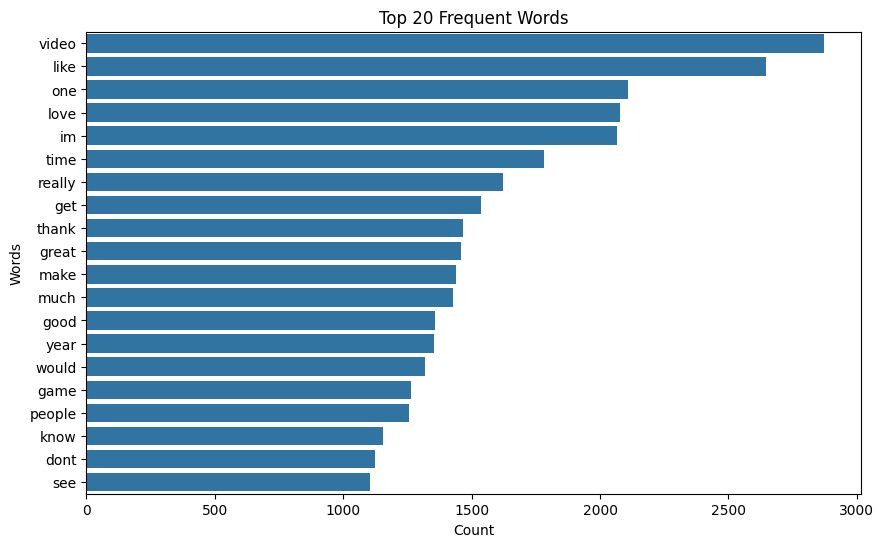

In [ ]:
from collections import Counter
# Flatten the tokens
all_words = ' '.join(df['Cleaned_Comment'])  # Use the correct column name here
word_freq = Counter(all_words.split())

# Plot top 20 words
common_words = word_freq.most_common(20)
words, counts = zip(*common_words)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words))
plt.title('Top 20 Frequent Words')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()

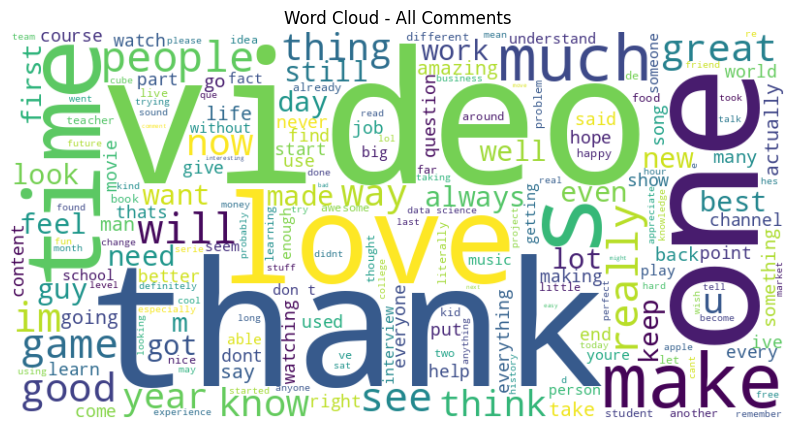

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_comments = ' '.join(df['Comment'])
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate(all_comments)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - All Comments")
plt.show()

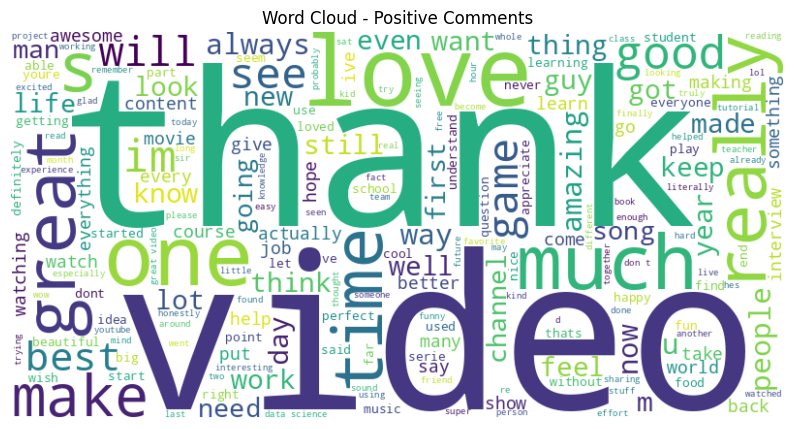

In [ ]:
#Positive Comments plot
positive_comments = ' '.join(df[df['Sentiment'].str.lower() == 'positive']['Comment'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_comments)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Positive Comments")
plt.show()

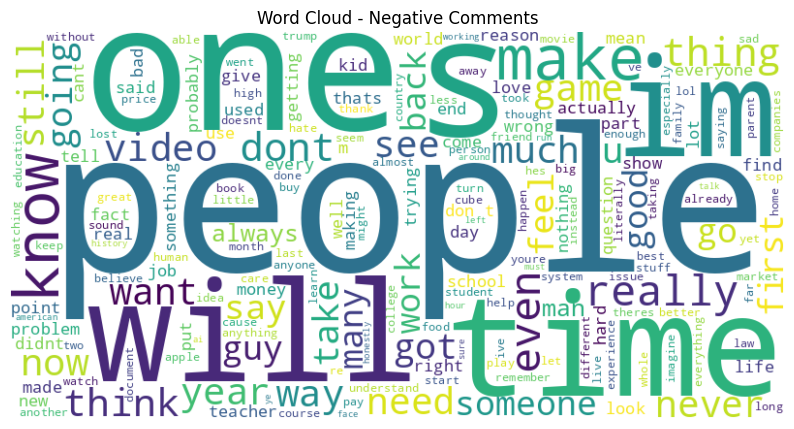

In [ ]:
#Negative Comments Plot
negative_comments = ' '.join(df[df['Sentiment'].str.lower() == 'negative']['Comment'])
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_comments)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Negative Comments")
plt.show()

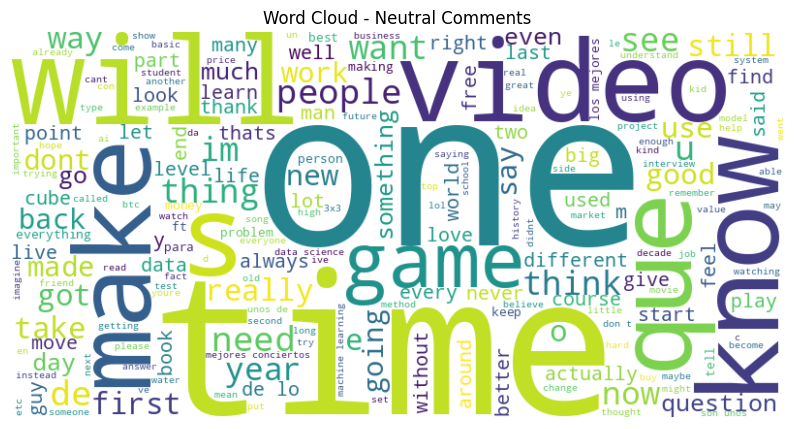

In [ ]:
#Neutral Comments Plot
neutral_comments = ' '.join(df[df['Sentiment'].str.lower() == 'neutral']['Comment'])
wordcloud_neu = WordCloud(width=800, height=400, background_color='white').generate(neutral_comments)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_neu, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Neutral Comments")
plt.show()

In [ ]:
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Sentiment'])

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X = tfidf.fit_transform(df['Cleaned'])
y = df['Label']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


<ipython-input-61-970377597590>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'] = le.fit_transform(df['Sentiment'])


In [ ]:
#Model Evaluation

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=150),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(kernel="linear", probability=True),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": lgb.LGBMClassifier()
}

trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:28:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.430242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122903
[LightGBM] [Info] Number of data points in the train set: 25483, number of used features: 4227
[LightGBM] [Info] Start training from score -1.098534
[LightGBM] [Info] Start training from score -1.098652
[LightGBM] [Info] Start training from score -1.098652


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


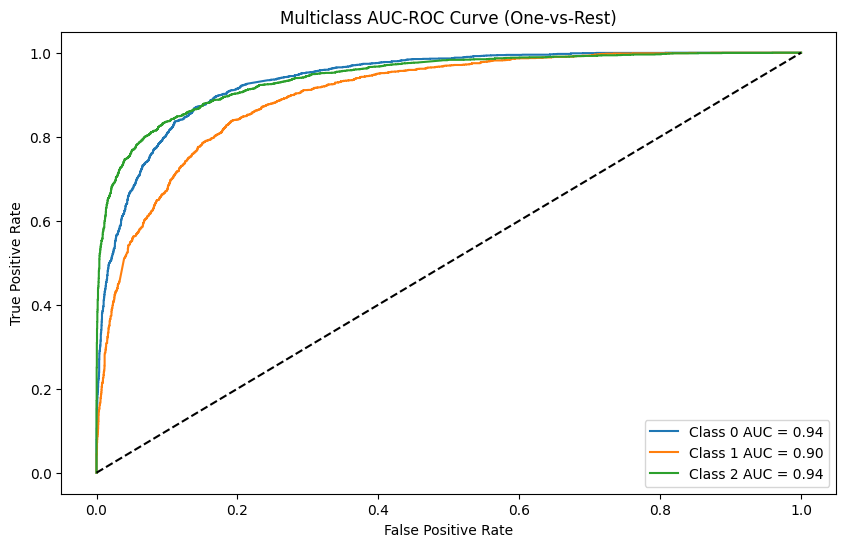

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for all classes
y_pred_proba = model.predict_proba(X_test)

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

n_classes = y_pred_proba.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])  # One-vs-rest
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} AUC = {roc_auc[i]:.2f}')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass AUC-ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()



🔹 Model: Logistic Regression
Accuracy: 81.15 %
Classification Report:
               precision    recall  f1-score   support

    negative       0.80      0.84      0.82      2123
     neutral       0.75      0.81      0.78      2124
    positive       0.90      0.79      0.84      2124

    accuracy                           0.81      6371
   macro avg       0.82      0.81      0.81      6371
weighted avg       0.82      0.81      0.81      6371



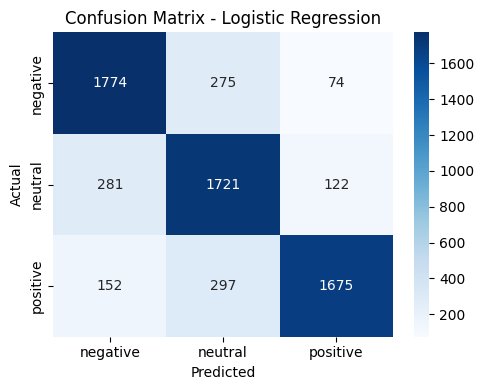


🔹 Model: Random Forest
Accuracy: 88.31 %
Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.93      0.91      2123
     neutral       0.86      0.86      0.86      2124
    positive       0.90      0.85      0.88      2124

    accuracy                           0.88      6371
   macro avg       0.88      0.88      0.88      6371
weighted avg       0.88      0.88      0.88      6371



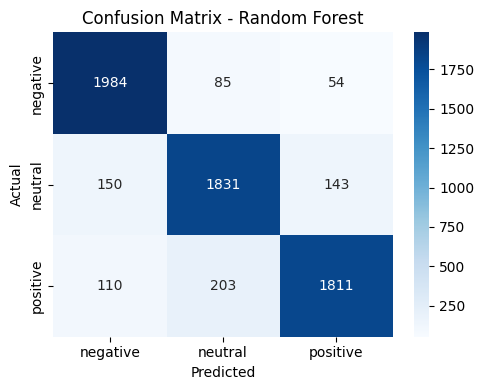


🔹 Model: Decision Tree
Accuracy: 80.46 %
Classification Report:
               precision    recall  f1-score   support

    negative       0.81      0.86      0.83      2123
     neutral       0.78      0.79      0.79      2124
    positive       0.82      0.77      0.79      2124

    accuracy                           0.80      6371
   macro avg       0.80      0.80      0.80      6371
weighted avg       0.80      0.80      0.80      6371



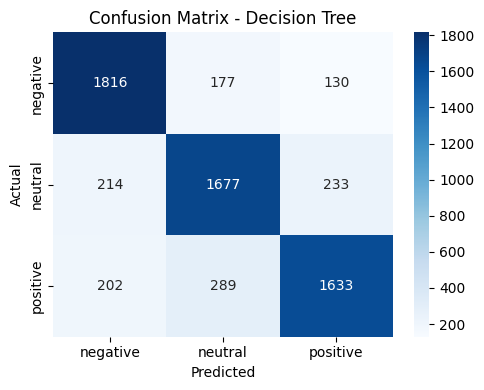


🔹 Model: Naive Bayes
Accuracy: 75.04 %
Classification Report:
               precision    recall  f1-score   support

    negative       0.69      0.92      0.79      2123
     neutral       0.84      0.52      0.65      2124
    positive       0.77      0.81      0.79      2124

    accuracy                           0.75      6371
   macro avg       0.77      0.75      0.74      6371
weighted avg       0.77      0.75      0.74      6371



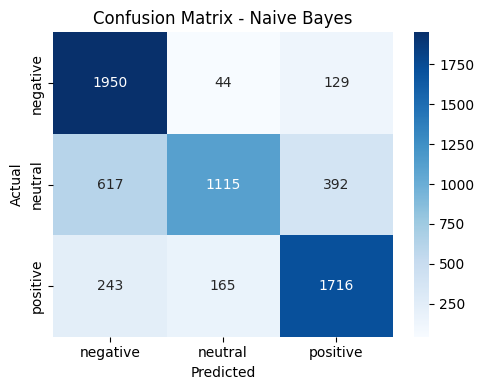


🔹 Model: SVM
Accuracy: 82.03 %
Classification Report:
               precision    recall  f1-score   support

    negative       0.82      0.83      0.83      2123
     neutral       0.75      0.84      0.79      2124
    positive       0.91      0.79      0.85      2124

    accuracy                           0.82      6371
   macro avg       0.83      0.82      0.82      6371
weighted avg       0.83      0.82      0.82      6371



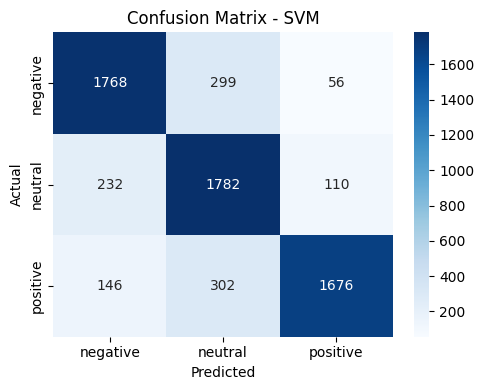


🔹 Model: XGBoost
Accuracy: 77.57 %
Classification Report:
               precision    recall  f1-score   support

    negative       0.79      0.76      0.78      2123
     neutral       0.69      0.80      0.74      2124
    positive       0.86      0.76      0.81      2124

    accuracy                           0.78      6371
   macro avg       0.78      0.78      0.78      6371
weighted avg       0.78      0.78      0.78      6371



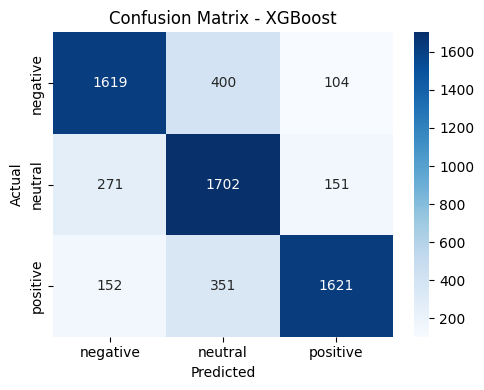


🔹 Model: LightGBM
Accuracy: 79.06 %


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Classification Report:
               precision    recall  f1-score   support

    negative       0.80      0.80      0.80      2123
     neutral       0.73      0.78      0.75      2124
    positive       0.85      0.79      0.82      2124

    accuracy                           0.79      6371
   macro avg       0.79      0.79      0.79      6371
weighted avg       0.79      0.79      0.79      6371



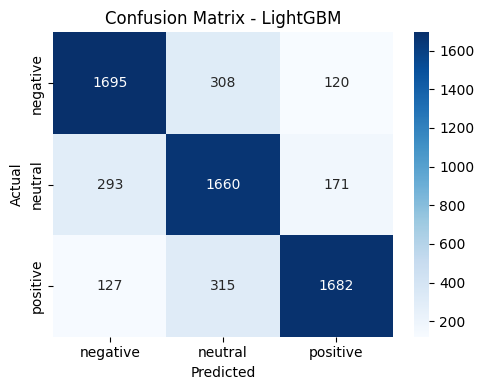

In [ ]:
for name, model in trained_models.items():
    print(f"\n🔹 Model: {name}")
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", round(acc * 100, 2), "%")
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-69-bf7308ca518f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=model_names, palette="coolwarm")


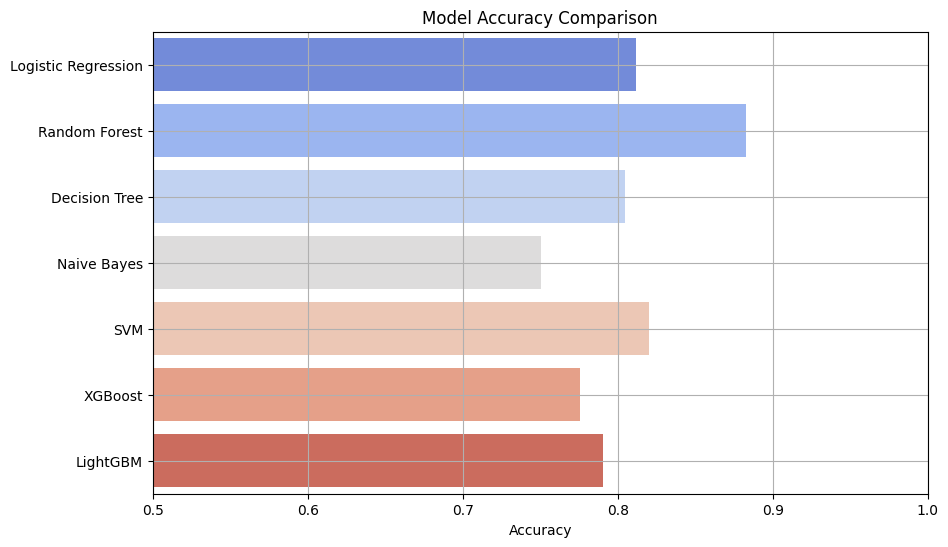

In [ ]:
model_names = list(trained_models.keys())
accuracies = [accuracy_score(y_test, model.predict(X_test)) for model in trained_models.values()]

plt.figure(figsize=(10, 6))
sns.barplot(x=accuracies, y=model_names, palette="coolwarm")
plt.title("Model Accuracy Comparison")
plt.xlabel("Accuracy")
plt.xlim(0.5, 1.0)
plt.grid(True)
plt.show()
